In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
np.random.seed(500)

In [3]:
df = pd.read_csv("sets_de_datos/train.csv", usecols = ['id','descripcion','precio'])

In [4]:
df

,id,descripcion,precio
0,254099,"depto. interior de 80.15m2, consta de sala com...",2273000.0
1,53461,"<p>entre sonora y guerrero, atr&aacute;s del h...",3600000.0
2,247984,descripcion \nla mejor ubicacion residencial e...,1200000.0
3,209067,casa en privada con caseta de vigilancia casas...,650000.0
4,185997,bonito departamento en excelentes condiciones ...,1150000.0
...,...,...,...
239995,119879,vendo casa en bosques de ica residencial a 10 ...,650000.0
239996,259178,"casa con un jardin amplio, un cuarto de servic...",1940000.0
239997,131932,"departamento con excelente ubicación, muy cerc...",3400000.0
239998,146867,"casa sola, dividida en cuatro departamentos de...",2890000.0


In [5]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def categorizar_precio(precio):
    categorias = [70,150,250,350,500,650,750]
    for i in range(len(categorias)):
        if precio < categorias[i]:
            return i
    return len(categorias) + 1

def quitar_tildes(descripcion):
    d = {'á':'a', 'é':'e','í':'i','ó':'o','ú':'u'}
    final = ''
    for letra in descripcion:
        final += d.get(letra, letra)
    return final

In [6]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
stop_words = stop_words_sp | stop_words_en

In [7]:
df['descripcion'] = df['descripcion'].fillna('e')\
    .map(lambda x: remove_tags(str(x)))\
    .map(lambda x: "".join([letra.lower() for letra in x if letra.isalpha() or letra == ' ']))\
    .map(lambda x: " ".join([palabra for palabra in x.split() if palabra not in stop_words_sp and len(palabra)>2]))\
    .map(quitar_tildes)

In [8]:
df['precio']/=10000

In [9]:
categorias = ['0-70','70-150','150-250','250-350','350-500','500-650','650-750']
df['categoria'] = df['precio'].transform(categorizar_precio)

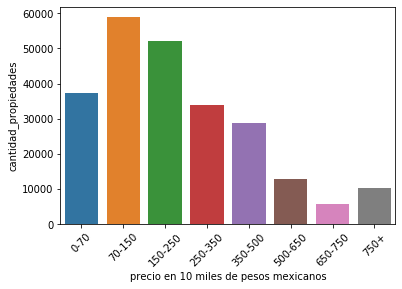

In [10]:
info_plot = pd.DataFrame({'precio': categorias + ['750+'], 'cantidad_propiedades':df.groupby('categoria').agg({'precio':'count'}).reset_index()['precio']})
sns.barplot(info_plot.precio, info_plot.cantidad_propiedades)
plt.xticks(rotation=45)
plt.xlabel('precio en 10 miles de pesos mexicanos')
plt.show()

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(df['descripcion'],df['categoria'],test_size=0.2)

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1000, ngram_range=(1, 2))

In [13]:
features = tfidf.fit_transform(df.descripcion).toarray()
labels = df.categoria
features.shape

(240000, 1650)

In [14]:
from sklearn.feature_selection import chi2
import numpy as np

In [15]:
bigramas_por_categoria = []
N = 4
for i in range(len(categorias)+1):
    features_chi2 = chi2(features, labels == i)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    bigramas = [v for v in feature_names if len(v.split(' ')) == 2]
    bigramas_por_categoria.append(bigramas[-N:])
    print("# '{}':".format(i))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigramas[-N:])))
print(bigramas_por_categoria)

# '0':
  . Most correlated bigrams:
. patio servicio
. cochera auto
. cocina tarja
. credito infonavit
# '1':
  . Most correlated bigrams:
. principal vestidor
. lavado cuarto
. servicio baño
. cuarto servicio
# '2':
  . Most correlated bigrams:
. recamaras principal
. recamaras baño
. credito infonavit
. principal baño
# '3':
  . Most correlated bigrams:
. principal vestidor
. cochera auto
. servicio baño
. cuarto servicio
# '4':
  . Most correlated bigrams:
. lavado cuarto
. patio servicio
. servicio baño
. cuarto servicio
# '5':
  . Most correlated bigrams:
. salon fiestas
. family room
. salon juegos
. cuarto servicio
# '6':
  . Most correlated bigrams:
. recamaras vestidor
. salon juegos
. cuarto servicio
. family room
# '7':
  . Most correlated bigrams:
. cualquier tipo
. cto servicio
. cristal templado
. cuarta recamara
[['patio servicio', 'cochera auto', 'cocina tarja', 'credito infonavit'], ['principal vestidor', 'lavado cuarto', 'servicio baño', 'cuarto servicio'], ['recamara

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(df['descripcion'], df['categoria'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, Y_train)

In [18]:
acum = 0 
for i in range(len(X_test)):
    if clf.predict(count_vect.transform([X_test.iloc[i]]))[0]-Y_test.iloc[i]:
        continue
    acum += 1
acum/len(X_test)

0.33915

In [57]:
final = []
for desc in df['descripcion']:
    categorias_features = []
    for bigramas in bigramas_por_categoria:
        acum = 0
        for bigrama in bigramas:
            if bigrama in desc:
                acum+=1
        categorias_features.append(acum)
    final.append(categorias_features)
final

[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 2, 0, 2, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0],
 [1, 2, 1, 2, 3, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 2, 2, 2, 2, 1, 1, 0],
 [0, 1, 0, 1, 1, 1, 1, 0],
 [0, 3, 2, 2, 3, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 0, 2, 1, 1, 1, 0],
 [0, 2, 0, 1, 2, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [2, 0, 1, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 2, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 2, 1, 1, 1, 0],
 [0, 2, 0, 2, 2, 1, 1, 1],
 [1, 1, 0, 1, 2, 1, 1, 0],
 [0, 2, 1, 2, 2, 2, 2, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 

In [58]:
features = pd.DataFrame(final)
features["id"] = df["id"]
features = features.set_index('id')
features.to_csv("data/descripciones_chi2.csv")

In [48]:
test_kaggle = pd.read_csv('sets_de_datos/test.csv', index_col = 0)
test_kaggle.descripcion = test_kaggle.descripcion.fillna('e')
final = []
for desc in test_kaggle['descripcion']:
    categorias_features = []
    for bigramas in bigramas_por_categoria:
        acum = 0
        for bigrama in bigramas:
            if bigrama in desc:
                acum+=1
        categorias_features.append(acum)
    final.append(categorias_features)
final

[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 

In [54]:
features = pd.DataFrame(final)
features["id"] = test_kaggle.reset_index()["id"]
features = features.set_index('id')
features.to_csv("data/descripciones_chi2_kaggle.csv")

In [55]:
features

,0,1,2,3,4,5,6,7
id,,,,,,,,
4941,0,0,0,0,0,0,0,0
51775,0,0,0,0,0,0,0,0
115253,0,0,0,0,0,0,0,0
299321,0,0,0,0,0,0,0,0
173570,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
75094,0,0,0,0,0,0,0,0
171847,0,0,0,0,0,0,0,0
138313,0,0,0,0,0,0,0,0
